# Préliminaire

In [30]:
import pandas as pd
import re
pd.set_option('display.max_columns', None)
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [31]:
df = pd.read_csv('regularite-mensuelle-tgv-aqst.csv',delimiter=';')

In [32]:
df = df[df["duree_moyenne"] > 0] #73 lignes n'obéissent pas à cette condition

In [33]:
#Utils
def select_test_data(data):
    data['date'] = data['date'].str.strip()  # Remove leading/trailing spaces if any

    # Define the regular expression pattern
    pattern = re.compile(r'^2023-\d{2}$', re.IGNORECASE)

    # Filter rows with the desired date format
    test_data = data[data['date'].str.contains(pattern, na=False)]
    return test_data

def select_train_data(data,test_data):
    # Find the indices of rows in 'data' that are not in 'test_data'
    indices_to_keep = ~data.index.isin(test_data.index)

    # Create the 'train_data' DataFrame by selecting rows from 'data' using the indices to keep
    train_data = data[indices_to_keep].reset_index(drop=True)
    return train_data


# Splitting data into features and labels
def split_data(df, drop_columns):
	X = df.drop(columns = drop_columns + ['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant',\
			'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs'])
	y = df[['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant',\
			'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']]

	return X, y

#Sppliting 'date' and O-H encoding
def date_service_proccess(train_data, test_data):
    df = pd.concat([train_data, test_data], axis=0)
    df[['année', 'mois']] = df['date'].str.split('-', expand=True) 
    df = df.drop(columns =['date', 'année'])

    df = pd.get_dummies(df, columns=['service', 'gare_depart', 'gare_arrivee'], dtype=int)

    train_data_encoded = df[:len(train_data)]
    test_data_encoded = df[len(train_data):]
    return train_data_encoded, test_data_encoded

In [34]:
#Convertion des pourcentages en réel entre 0 et 1
percentage_columns = ['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic', 'prct_cause_materiel_roulant',\
			'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs']

for column in percentage_columns:
    df[column] = df[column] / 100

In [35]:
df.head()

,date,service,gare_depart,gare_arrivee,duree_moyenne,nb_train_prevu,nb_annulation,commentaire_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,commentaire_retards_depart,nb_train_retard_arrivee,retard_moyen_arrivee,retard_moyen_tous_trains_arrivee,commentaires_retard_arrivee,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,2018-01,National,BORDEAUX ST JEAN,PARIS MONTPARNASSE,141,870,5,NaN,289,11.247809,3.693179,NaN,147,28.436735,6.511118,NaN,110,6.511118,44,8,0.361345,0.310924,0.109244,0.159664,0.050420,0.008403
1,2018-01,National,LA ROCHELLE VILLE,PARIS MONTPARNASSE,165,222,0,NaN,8,2.875000,0.095796,NaN,34,21.524020,5.696096,NaN,22,5.696096,5,0,0.153846,0.307692,0.384615,0.115385,0.038462,0.000000
2,2018-01,National,PARIS MONTPARNASSE,QUIMPER,220,248,1,NaN,37,9.501351,1.003981,NaN,26,55.692308,7.578947,"Ce mois-ci, l'OD a été touchée par les inciden...",26,7.548387,17,7,0.269231,0.384615,0.153846,0.192308,0.000000,0.000000
3,2018-01,National,PARIS MONTPARNASSE,ST MALO,156,102,0,NaN,12,19.912500,1.966667,NaN,13,48.623077,6.790686,"Ce mois-ci, l'OD a été touchée par les inciden...",8,6.724757,6,4,0.230769,0.461538,0.076923,0.153846,0.076923,0.000000
4,2018-01,National,PARIS MONTPARNASSE,ST PIERRE DES CORPS,61,391,2,NaN,61,7.796995,0.886889,NaN,71,12.405164,3.346487,NaN,17,3.346487,6,0,0.212121,0.424242,0.090909,0.212121,0.060606,0.000000


# Niveaux de réstriction & Séparation des données train/test

Niveaux de restriction: <br>
	1- Enlever l’autre colonne retard <br>
	2- + Enlever les colonnes: nb_train_retard_sup15 , retard_moyen_trains_retard_sup_15 , nb_train_retard_sup_30 , nb_train_retard_sup_60 <br>
	3- + Enlever les colonnes: nb_train_retard_arrivee <br>
	4- + Enlever les colonnes: nb_train_retard_depart , retard_moyen_depart , retard_moyen_tous_trains_depart <br>
	5- + Enlever les colonnes: nb_annulation <br>

In [83]:
remove_columns_0 = ['prct_cause_externe', 'prct_cause_infra', 'prct_cause_gestion_trafic',
'prct_cause_materiel_roulant', 'prct_cause_gestion_gare', 'prct_cause_prise_en_charge_voyageurs', 'commentaire_annulation', 'commentaire_retards_depart', 'commentaires_retard_arrivee']
remove_columns_1 = ['retard_moyen_tous_trains_arrivee']
remove_columns_2 = remove_columns_1 + ['nb_train_retard_sup_15' , 'retard_moyen_trains_retard_sup15' , 'nb_train_retard_sup_30' , 'nb_train_retard_sup_60']
remove_columns_3 = remove_columns_2 + ['nb_train_retard_arrivee']
remove_columns_4 = remove_columns_3 + ['nb_train_depart_retard' , 'retard_moyen_depart' , 'retard_moyen_tous_trains_depart']
remove_columns_5 = remove_columns_4 + ['nb_annulation']
L_remove = [remove_columns_1, remove_columns_2, remove_columns_3, remove_columns_4, remove_columns_5]

In [37]:
remove_columns = remove_columns_0

In [38]:
#the test data before preprocessing
test_data=select_test_data(df)
test_data.head()

# The training data before preprocessing
train_data = select_train_data(df, test_data)
train_data.head()

train_data_encoded, test_data_encoded = date_service_proccess(train_data, test_data)

X_train, y_train = split_data(train_data_encoded, remove_columns)
X_test, y_test = split_data(test_data_encoded, remove_columns)

In [39]:
X_train

,duree_moyenne,nb_train_prevu,nb_annulation,nb_train_depart_retard,retard_moyen_depart,retard_moyen_tous_trains_depart,nb_train_retard_arrivee,retard_moyen_arrivee,retard_moyen_tous_trains_arrivee,nb_train_retard_sup_15,retard_moyen_trains_retard_sup15,nb_train_retard_sup_30,nb_train_retard_sup_60,mois,service_International,service_National,gare_depart_AIX EN PROVENCE TGV,gare_depart_ANGERS SAINT LAUD,gare_depart_ANGOULEME,gare_depart_ANNECY,gare_depart_ARRAS,gare_depart_AVIGNON TGV,gare_depart_BARCELONA,gare_depart_BELLEGARDE (AIN),gare_depart_BESANCON FRANCHE COMTE TGV,gare_depart_BORDEAUX ST JEAN,gare_depart_BREST,gare_depart_CHAMBERY CHALLES LES EAUX,gare_depart_DIJON VILLE,gare_depart_DOUAI,gare_depart_DUNKERQUE,gare_depart_FRANCFORT,gare_depart_GENEVE,gare_depart_GRENOBLE,gare_depart_ITALIE,gare_depart_LA ROCHELLE VILLE,gare_depart_LAUSANNE,gare_depart_LAVAL,gare_depart_LE CREUSOT MONTCEAU MONTCHANIN,gare_depart_LE MANS,gare_depart_LILLE,gare_depart_LYON PART DIEU,gare_depart_MACON LOCHE,gare_depart_MADRID,gare_depart_MARNE LA VALLEE,gare_depart_MARSEILLE ST CHARLES,gare_depart_METZ,gare_depart_MONTPELLIER,gare_depart_MULHOUSE VILLE,gare_depart_NANCY,gare_depart_NANTES,gare_depart_NICE VILLE,gare_depart_NIMES,gare_depart_PARIS EST,gare_depart_PARIS LYON,gare_depart_PARIS MONTPARNASSE,gare_depart_PARIS NORD,gare_depart_PARIS VAUGIRARD,gare_depart_PERPIGNAN,gare_depart_POITIERS,gare_depart_QUIMPER,gare_depart_REIMS,gare_depart_RENNES,gare_depart_SAINT ETIENNE CHATEAUCREUX,gare_depart_ST MALO,gare_depart_ST PIERRE DES CORPS,gare_depart_STRASBOURG,gare_depart_STUTTGART,gare_depart_TOULON,gare_depart_TOULOUSE MATABIAU,gare_depart_TOURCOING,gare_depart_TOURS,gare_depart_VALENCE ALIXAN TGV,gare_depart_VANNES,gare_depart_ZURICH,gare_arrivee_AIX EN PROVENCE TGV,gare_arrivee_ANGERS SAINT LAUD,gare_arrivee_ANGOULEME,gare_arrivee_ANNECY,gare_arrivee_ARRAS,gare_arrivee_AVIGNON TGV,gare_arrivee_BARCELONA,gare_arrivee_BELLEGARDE (AIN),gare_arrivee_BESANCON FRANCHE COMTE TGV,gare_arrivee_BORDEAUX ST JEAN,gare_arrivee_BREST,gare_arrivee_CHAMBERY CHALLES LES EAUX,gare_arrivee_DIJON VILLE,gare_arrivee_DOUAI,gare_arrivee_DUNKERQUE,gare_arrivee_FRANCFORT,gare_arrivee_GENEVE,gare_arrivee_GRENOBLE,gare_arrivee_ITALIE,gare_arrivee_LA ROCHELLE VILLE,gare_arrivee_LAUSANNE,gare_arrivee_LAVAL,gare_arrivee_LE CREUSOT MONTCEAU MONTCHANIN,gare_arrivee_LE MANS,gare_arrivee_LILLE,gare_arrivee_LYON PART DIEU,gare_arrivee_MACON LOCHE,gare_arrivee_MADRID,gare_arrivee_MARNE LA VALLEE,gare_arrivee_MARSEILLE ST CHARLES,gare_arrivee_METZ,gare_arrivee_MONTPELLIER,gare_arrivee_MULHOUSE VILLE,gare_arrivee_NANCY,gare_arrivee_NANTES,gare_arrivee_NICE VILLE,gare_arrivee_NIMES,gare_arrivee_PARIS EST,gare_arrivee_PARIS LYON,gare_arrivee_PARIS MONTPARNASSE,gare_arrivee_PARIS NORD,gare_arrivee_PARIS VAUGIRARD,gare_arrivee_PERPIGNAN,gare_arrivee_POITIERS,gare_arrivee_QUIMPER,gare_arrivee_REIMS,gare_arrivee_RENNES,gare_arrivee_SAINT ETIENNE CHATEAUCREUX,gare_arrivee_ST MALO,gare_arrivee_ST PIERRE DES CORPS,gare_arrivee_STRASBOURG,gare_arrivee_STUTTGART,gare_arrivee_TOULON,gare_arrivee_TOULOUSE MATABIAU,gare_arrivee_TOURCOING,gare_arrivee_TOURS,gare_arrivee_VALENCE ALIXAN TGV,gare_arrivee_VANNES,gare_arrivee_ZURICH
0,141,870,5,289,11.247809,3.693179,147,28.436735,6.511118,110,6.511118,44,8,01,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,165,222,0,8,2.875000,0.095796,34,21.524020,5.696096,22,5.696096,5,0,01,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,220,248,1,37,9.501351,1.003981,26,55.692308,7.578947,26,7.548387,17,7,01,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [40]:
y_train

,prct_cause_externe,prct_cause_infra,prct_cause_gestion_trafic,prct_cause_materiel_roulant,prct_cause_gestion_gare,prct_cause_prise_en_charge_voyageurs
0,0.361345,0.310924,0.109244,0.159664,0.050420,0.008403
1,0.153846,0.307692,0.384615,0.115385,0.038462,0.000000
2,0.269231,0.384615,0.153846,0.192308,0.000000,0.000000
3,0.230769,0.461538,0.076923,0.153846,0.076923,0.000000
4,0.212121,0.424242,0.090909,0.212121,0.060606,0.000000
...,...,...,...,...,...,...
7350,0.230769,0.192308,0.230769,0.230769,0.076923,0.038462
7351,0.220238,0.184524,0.226190,0.244048,0.029762,0.095238
7352,0.500000,0.000000,0.100000,0.100000,0.100000,0.200000
7353,0.072993,0.029197,0.452555,0.240876,0.138686,0.065693


# Réseau de neurones simple

In [67]:
# Define a simple neural network model
class PercentagePredictionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(PercentagePredictionModel, self).__init__()
        self.fc = nn.Linear(input_size, output_size)

    def forward(self, x):
        x = self.fc(x)
        return torch.softmax(x, dim=1)  # Apply softmax to get percentages that sum up to 100

# Define the input and target data
X_train_tensor = torch.tensor(X_train.to_numpy(dtype='float32'))
y_train_tensor = torch.tensor(y_train.to_numpy(dtype='float32'))
X_test_tensor = torch.tensor(X_test.to_numpy(dtype='float32'))
y_test_tensor = torch.tensor(y_test.to_numpy(dtype='float32'))

In [68]:
# Create data loaders for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

In [78]:
# Create an instance of the model
model = PercentagePredictionModel(input_size=X_train_tensor.shape[1], output_size=y_train_tensor.shape[1])

# Define the loss function and optimizer
# criterion = nn.MSELoss()  # MSE
criterion = nn.KLDivLoss(reduction='batchmean')  # KL Divergence

optimizer = optim.Adam(model.parameters())

In [79]:
# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')

Epoch [100/1000]
Epoch [200/1000]
Epoch [300/1000]
Epoch [400/1000]
Epoch [500/1000]
Epoch [600/1000]
Epoch [700/1000]
Epoch [800/1000]
Epoch [900/1000]
Epoch [1000/1000]


In [59]:
all_predictions = []  # Store all predicted percentages
all_targets = []  # Store all true percentages

with torch.no_grad():
    for inputs, targets in test_loader:
        predicted_percentages = model(inputs)
        all_predictions.append(100 * predicted_percentages)
        all_targets.append(100 * targets)

# Concatenate the lists of predictions and targets
all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Calculate Errors
rmse = np.sqrt(mean_squared_error(all_targets, all_predictions, multioutput='raw_values'))
mae = mean_absolute_error(all_targets, all_predictions, multioutput='raw_values')

# print("Niveau de réstriction ", i)
print("    RMSE : ", rmse)   
print("    ", np.average(rmse))
print("    MAE  : ", mae)   
print("    ", np.average(mae))

# RMSE_model.append(np.average(rmse))
# MAE_model.append(np.average(mae))
# i += 1


# Loss = MSE

    RMSE :  [17.762815  12.508716  14.558559  12.673818   7.5162873  8.23907  ]
     12.209877
    MAE  :  [15.16422    9.593042  10.673545   9.3675785  5.525395   6.1259584]
     9.40829


In [80]:
all_predictions = []  # Store all predicted percentages
all_targets = []  # Store all true percentages

with torch.no_grad():
    for inputs, targets in test_loader:
        predicted_percentages = model(inputs)
        all_predictions.append(100 * predicted_percentages)
        all_targets.append(100 * targets)

# Concatenate the lists of predictions and targets
all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Calculate Errors
rmse = np.sqrt(mean_squared_error(all_targets, all_predictions, multioutput='raw_values'))
mae = mean_absolute_error(all_targets, all_predictions, multioutput='raw_values')

# print("Niveau de réstriction ", i)
print("    RMSE : ", rmse)   
print("    ", np.average(rmse))
print("    MAE  : ", mae)   
print("    ", np.average(mae))

# RMSE_model.append(np.average(rmse))
# MAE_model.append(np.average(mae))
# i += 1


# Loss = KL Divergence

    RMSE :  [66.558815 24.046816 43.892406 24.649141 11.522219 11.944353]
     30.435623
    MAE  :  [58.870113 20.412966 33.708923 20.953466  8.428687  8.634853]
     25.168167


L'utilisation de MSE comme loss produit de meilleurs résultats que KL Divergence. 


Evaluation du modèle pour différents niveaux de réstriction:

In [85]:
i = 1
RMSE_model = []
MAE_model = []
for rm in L_remove:
    print("Niveau de réstriction ", i)
    X_train2 = X_train.drop(columns=rm)
    X_test2 = X_test.drop(columns=rm)
    # Define the input and target data
    X_train_tensor = torch.tensor(X_train2.to_numpy(dtype='float32'))
    y_train_tensor = torch.tensor(y_train.to_numpy(dtype='float32'))
    X_test_tensor = torch.tensor(X_test2.to_numpy(dtype='float32'))
    y_test_tensor = torch.tensor(y_test.to_numpy(dtype='float32'))
    # Create data loaders for training and testing
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32)
    # Create an instance of the model
    model = PercentagePredictionModel(input_size=X_train_tensor.shape[1], output_size=y_train_tensor.shape[1])

    # Define the loss function and optimizer
    criterion = nn.MSELoss()  # MSE
    # criterion = nn.KLDivLoss(reduction='batchmean')  # KL Divergence

    optimizer = optim.Adam(model.parameters())

    # Training loop
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            # Forward pass
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, targets)
            
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    all_predictions = []  # Store all predicted percentages
    all_targets = []  # Store all true percentages

    with torch.no_grad():
        for inputs, targets in test_loader:
            predicted_percentages = model(inputs)
            all_predictions.append(100 * predicted_percentages)
            all_targets.append(100 * targets)

    # Concatenate the lists of predictions and targets
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Calculate Errors
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions, multioutput='raw_values'))
    mae = mean_absolute_error(all_targets, all_predictions, multioutput='raw_values')

    # print("Niveau de réstriction ", i)
    print("    RMSE : ", rmse)   
    print("    ", np.average(rmse))
    print("    MAE  : ", mae)   
    print("    ", np.average(mae))

    RMSE_model.append(np.average(rmse))
    MAE_model.append(np.average(mae))
    i += 1
    

Niveau de réstriction  1
    RMSE :  [13.182178  13.253978  13.401577  12.309538   7.3091307  8.1803465]
     11.272792
    MAE  :  [10.10769  10.693826  9.455783  9.050924  5.6164    6.079901]
     8.500754
Niveau de réstriction  2
    RMSE :  [14.577743  12.421281  12.463633  12.702735   7.3393292  8.189271 ]
     11.282332
    MAE  :  [11.754733  9.373541  8.786013  9.403136  5.603114  6.132902]
     8.508906
Niveau de réstriction  3
    RMSE :  [13.433754  12.833399  12.946612  11.907127   7.2866178  9.080658 ]
     11.248028
    MAE  :  [10.63831    9.990763   9.013881   8.8134775  5.640373   6.7983284]
     8.482522
Niveau de réstriction  4
    RMSE :  [12.696052 12.517158 12.827656 12.660669  7.675976  7.85861 ]
     11.039352
    MAE  :  [9.3928   9.790197 9.103347 9.623918 5.776814 5.620035]
     8.217853
Niveau de réstriction  5
    RMSE :  [13.677965 12.41093  13.064341 13.015175  8.330071  8.023896]
     11.420396
    MAE  :  [10.568443   9.385243   9.045352   9.878136   6.

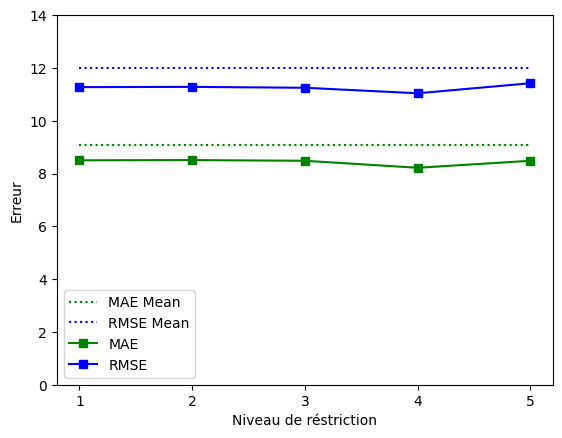

In [87]:
RMSE_mean = [11.99] * 5
MAE_mean = [9.08] * 5
restriction_plot = list(range(1, 6))
plt.plot(restriction_plot, MAE_mean, linestyle=':', color='green', label='MAE Mean')
plt.plot(restriction_plot, RMSE_mean, linestyle=':', color='blue', label='RMSE Mean')
plt.plot(restriction_plot, MAE_model, marker='s', color='green', label='MAE')
plt.plot(restriction_plot, RMSE_model, marker='s', color='blue', label='RMSE')

plt.xlabel("Niveau de réstriction")
plt.ylabel("Erreur")
plt.legend()
plt.xticks(restriction_plot)
plt.ylim(0, 14)

plt.show()

# Réseau de neurones à 3 couches

In [91]:
# Define a simple neural network model
class PercentagePredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PercentagePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        return torch.softmax(x, dim=1)  # Apply softmax to get percentages that sum up to 100

# Define the input and target data
X_train_tensor = torch.tensor(X_train.to_numpy(dtype='float32'))
y_train_tensor = torch.tensor(y_train.to_numpy(dtype='float32'))
X_test_tensor = torch.tensor(X_test.to_numpy(dtype='float32'))
y_test_tensor = torch.tensor(y_test.to_numpy(dtype='float32'))

In [92]:
# Create data loaders for training and testing
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

In [102]:
# Create an instance of the model
model = PercentagePredictionModel(input_size=X_train_tensor.shape[1], hidden_size=2 * X_train_tensor.shape[1], output_size=y_train_tensor.shape[1])

# Define the loss function and optimizer
criterion = nn.MSELoss()  # MSE
# criterion = nn.KLDivLoss(reduction='batchmean')  # KL Divergence

optimizer = optim.Adam(model.parameters())

In [103]:
# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        # Forward pass
        outputs = model(inputs)
        
        # Calculate the loss
        loss = criterion(outputs, targets)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}]')

Epoch [100/1000]
Epoch [200/1000]
Epoch [300/1000]
Epoch [400/1000]
Epoch [500/1000]
Epoch [600/1000]
Epoch [700/1000]
Epoch [800/1000]
Epoch [900/1000]
Epoch [1000/1000]


In [101]:
all_predictions = []  # Store all predicted percentages
all_targets = []  # Store all true percentages

with torch.no_grad():
    for inputs, targets in test_loader:
        predicted_percentages = model(inputs)
        all_predictions.append(100 * predicted_percentages)
        all_targets.append(100 * targets)

# Concatenate the lists of predictions and targets
all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Calculate Errors
rmse = np.sqrt(mean_squared_error(all_targets, all_predictions, multioutput='raw_values'))
mae = mean_absolute_error(all_targets, all_predictions, multioutput='raw_values')

# print("Niveau de réstriction ", i)
print("    RMSE : ", rmse)   
print("    ", np.average(rmse))
print("    MAE  : ", mae)   
print("    ", np.average(mae))

# RMSE_model.append(np.average(rmse))
# MAE_model.append(np.average(mae))
# i += 1


# Loss = MSE

    RMSE :  [14.500629  12.317898  12.792012  12.753139   7.6338553  8.1921425]
     11.364945
    MAE  :  [10.914291  9.199845  8.959841  9.424012  5.51746   6.050406]
     8.34431


In [104]:
all_predictions = []  # Store all predicted percentages
all_targets = []  # Store all true percentages

with torch.no_grad():
    for inputs, targets in test_loader:
        predicted_percentages = model(inputs)
        all_predictions.append(100 * predicted_percentages)
        all_targets.append(100 * targets)

# Concatenate the lists of predictions and targets
all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Calculate Errors
rmse = np.sqrt(mean_squared_error(all_targets, all_predictions, multioutput='raw_values'))
mae = mean_absolute_error(all_targets, all_predictions, multioutput='raw_values')

# print("Niveau de réstriction ", i)
print("    RMSE : ", rmse)   
print("    ", np.average(rmse))
print("    MAE  : ", mae)   
print("    ", np.average(mae))

# RMSE_model.append(np.average(rmse))
# MAE_model.append(np.average(mae))
# i += 1


# Loss = MSE, hidden layer size * 2

    RMSE :  [15.05864  13.348162 12.577144 13.571144  8.479854  9.193187]
     12.038021
    MAE  :  [11.001443   9.994832   9.045709   9.131441   5.804081   6.6776443]
     8.609191


In [98]:
all_predictions = []  # Store all predicted percentages
all_targets = []  # Store all true percentages

with torch.no_grad():
    for inputs, targets in test_loader:
        predicted_percentages = model(inputs)
        all_predictions.append(100 * predicted_percentages)
        all_targets.append(100 * targets)

# Concatenate the lists of predictions and targets
all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Calculate Errors
rmse = np.sqrt(mean_squared_error(all_targets, all_predictions, multioutput='raw_values'))
mae = mean_absolute_error(all_targets, all_predictions, multioutput='raw_values')

# print("Niveau de réstriction ", i)
print("    RMSE : ", rmse)   
print("    ", np.average(rmse))
print("    MAE  : ", mae)   
print("    ", np.average(mae))

# RMSE_model.append(np.average(rmse))
# MAE_model.append(np.average(mae))
# i += 1


# Loss = KL Divergence

    RMSE :  [80.92323  24.046816 25.921686 24.649143 11.522219 11.944353]
     29.834574
    MAE  :  [79.738304 20.412966 21.0329   20.953466  8.428687  8.634853]
     26.53353


La meilleure performance est obtenue avec la loss MSE et un nombre de couches égal à la taille de l'input.

In [105]:
i = 1
RMSE_model2 = []
MAE_model2 = []
for rm in L_remove:
    print("Niveau de réstriction ", i)
    X_train2 = X_train.drop(columns=rm)
    X_test2 = X_test.drop(columns=rm)
    # Define the input and target data
    X_train_tensor = torch.tensor(X_train2.to_numpy(dtype='float32'))
    y_train_tensor = torch.tensor(y_train.to_numpy(dtype='float32'))
    X_test_tensor = torch.tensor(X_test2.to_numpy(dtype='float32'))
    y_test_tensor = torch.tensor(y_test.to_numpy(dtype='float32'))
    # Create data loaders for training and testing
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=32)
    # Create an instance of the model
    model = PercentagePredictionModel(input_size=X_train_tensor.shape[1], hidden_size=X_train_tensor.shape[1], output_size=y_train_tensor.shape[1])

    # Define the loss function and optimizer
    criterion = nn.MSELoss()  # MSE
    # criterion = nn.KLDivLoss(reduction='batchmean')  # KL Divergence

    optimizer = optim.Adam(model.parameters())

    # Training loop
    num_epochs = 1000
    for epoch in range(num_epochs):
        model.train()
        for inputs, targets in train_loader:
            # Forward pass
            outputs = model(inputs)
            
            # Calculate the loss
            loss = criterion(outputs, targets)
            
            # Backpropagation and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
    all_predictions = []  # Store all predicted percentages
    all_targets = []  # Store all true percentages

    with torch.no_grad():
        for inputs, targets in test_loader:
            predicted_percentages = model(inputs)
            all_predictions.append(100 * predicted_percentages)
            all_targets.append(100 * targets)

    # Concatenate the lists of predictions and targets
    all_predictions = torch.cat(all_predictions, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Calculate Errors
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions, multioutput='raw_values'))
    mae = mean_absolute_error(all_targets, all_predictions, multioutput='raw_values')

    # print("Niveau de réstriction ", i)
    print("    RMSE : ", rmse)   
    print("    ", np.average(rmse))
    print("    MAE  : ", mae)   
    print("    ", np.average(mae))

    RMSE_model2.append(np.average(rmse))
    MAE_model2.append(np.average(mae))
    i += 1
    

Niveau de réstriction  1
    RMSE :  [14.552413  12.264257  13.0527525 12.570635   7.769915  10.235402 ]
     11.740895
    MAE  :  [10.457998   8.939664   9.2741585  8.839171   5.487532   6.601054 ]
     8.266597
Niveau de réstriction  2
    RMSE :  [14.958545 13.638571 12.537835 12.431571  9.026217  8.442486]
     11.839204
    MAE  :  [11.09021    9.821934   8.741586   9.221546   5.9803863  6.1372075]
     8.498811
Niveau de réstriction  3
    RMSE :  [15.911804 12.342057 12.606709 12.942268  8.360748  9.201386]
     11.894162
    MAE  :  [12.443149  9.331152  8.80561   9.097769  5.901721  6.526243]
     8.684274
Niveau de réstriction  4
    RMSE :  [16.611189 14.037636 13.01884  12.432967  7.958149  9.231173]
     12.214992
    MAE  :  [13.395321 10.744577  9.173755  9.010567  5.800326  6.312334]
     9.072814
Niveau de réstriction  5
    RMSE :  [14.429909 12.737937 13.084936 12.119143  8.766045  8.123824]
     11.5436325
    MAE  :  [10.99956    9.454506   8.935192   8.777928   5

In [108]:
RMSE_model_a = [10.50285871660636,
 10.621260536527869,
 10.654379641519034,
 10.696684717416398,
 10.670531417848416]
MAE_model_a = [7.848704726101494,
 7.974770312549583,
 8.01698723367581,
 8.055604880088858,
 8.025946784116641]

# Comparaison des performances

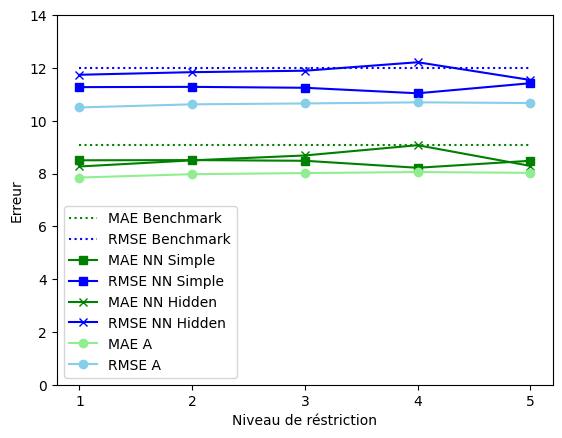

In [115]:
RMSE_mean = [11.99] * 5
MAE_mean = [9.08] * 5
restriction_plot = list(range(1, 6))
plt.plot(restriction_plot, MAE_mean, linestyle=':', color='green', label='MAE Benchmark')
plt.plot(restriction_plot, RMSE_mean, linestyle=':', color='blue', label='RMSE Benchmark')
plt.plot(restriction_plot, MAE_model, marker='s', color='green', label='MAE NN Simple')
plt.plot(restriction_plot, RMSE_model, marker='s', color='blue', label='RMSE NN Simple')
plt.plot(restriction_plot, MAE_model2, marker='x', color='green', label='MAE NN Hidden')
plt.plot(restriction_plot, RMSE_model2, marker='x', color='blue', label='RMSE NN Hidden')
plt.plot(restriction_plot, MAE_model_a, marker='o', color='lightgreen' , label='MAE A')
plt.plot(restriction_plot, RMSE_model_a, marker='o', color='skyblue', label='RMSE A')

plt.xlabel("Niveau de réstriction")
plt.ylabel("Erreur")
plt.legend()
plt.xticks(restriction_plot)
plt.ylim(0, 14)

plt.show()